In [0]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image

In [0]:
filename_read = os.path.join("drive/My Drive/Data/HousesInfo.txt")

In [0]:
cols=["Bedrooms","Bathrooms","area","zipcode","price"]

In [0]:
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)

In [106]:
df.shape

(535, 5)

In [107]:
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [108]:
items_counts=df['zipcode'].value_counts()

items_counts


92276    100
93510     60
93446     54
92880     49
94501     41
91901     32
92677     26
94531     22
85255     12
96019     12
93111     11
92021     11
85266     11
81524     11
95220     10
92802      9
85262      9
62234      7
62214      4
98021      4
85377      3
60002      3
91752      3
81418      2
62025      2
92692      2
92253      2
60016      2
93924      1
90211      1
90038      1
93314      1
90265      1
93105      1
92040      1
62249      1
95008      1
91915      1
62034      1
85331      1
94565      1
94568      1
92543      1
60046      1
62088      1
81521      1
36372      1
93720      1
90803      1
Name: zipcode, dtype: int64

In [109]:
vc = df.zipcode.value_counts()
vc[vc<22]
x=vc[vc<22].index.tolist()
x

[85255,
 96019,
 93111,
 92021,
 85266,
 81524,
 95220,
 92802,
 85262,
 62234,
 62214,
 98021,
 85377,
 60002,
 91752,
 81418,
 62025,
 92692,
 92253,
 60016,
 93924,
 90211,
 90038,
 93314,
 90265,
 93105,
 92040,
 62249,
 95008,
 91915,
 62034,
 85331,
 94565,
 94568,
 92543,
 60046,
 62088,
 81521,
 36372,
 93720,
 90803]

In [110]:
newzip=df[df['zipcode'].isin(x)].index
newzip

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            282, 504, 505, 506, 507, 508, 509, 510, 511, 512],
           dtype='int64', length=151)

In [111]:
newzip.shape

(151,)

In [112]:
items_counts.count()

49

In [0]:
df=df.drop(newzip)

In [114]:
df.shape

(384, 5)

In [0]:
df['y'] = df['price']


In [0]:
y = df[['y']].copy()
x = df.drop(['y'], axis = 1)

In [117]:
x.shape,y.shape

((384, 5), (384, 1))

In [0]:
encode_text_dummy(df,'Bedrooms')
encode_text_dummy(df,'Bathrooms')
encode_numeric_zscore(df,'area')
encode_text_dummy(df,'zipcode')
encode_numeric_zscore(df,'price')

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=33)

In [0]:
new_images=[]
for number in range(1, 536):
    for path in glob.glob("drive/My Drive/Data/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 

In [0]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [0]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("drive/My Drive/Data/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 

In [0]:
img['bedroom_img']=bedroom_images

In [0]:
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("drive/My Drive/Data/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 

In [0]:
img['frontal_img']=frontal_images

In [0]:
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("drive/My Drive/Data/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

In [0]:
img['kitchen_img']=kitchen_images

In [128]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,drive/My Drive/Data/1_bathroom.jpg,drive/My Drive/Data/1_bedroom.jpg,drive/My Drive/Data/1_frontal.jpg,drive/My Drive/Data/1_kitchen.jpg
1,drive/My Drive/Data/2_bathroom.jpg,drive/My Drive/Data/2_bedroom.jpg,drive/My Drive/Data/2_frontal.jpg,drive/My Drive/Data/2_kitchen.jpg
2,drive/My Drive/Data/3_bathroom.jpg,drive/My Drive/Data/3_bedroom.jpg,drive/My Drive/Data/3_frontal.jpg,drive/My Drive/Data/3_kitchen.jpg
3,drive/My Drive/Data/4_bathroom.jpg,drive/My Drive/Data/4_bedroom.jpg,drive/My Drive/Data/4_frontal.jpg,drive/My Drive/Data/4_kitchen.jpg
4,drive/My Drive/Data/5_bathroom.jpg,drive/My Drive/Data/5_bedroom.jpg,drive/My Drive/Data/5_frontal.jpg,drive/My Drive/Data/5_kitchen.jpg


In [129]:
#img.drop(index1)
img = img.drop(newzip)

img.shape

(384, 4)

In [130]:
img.shape

(384, 4)

In [0]:
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]
            
        
            images_output.append(outputImage)      
            

In [ ]:
from matplotlib import pyplot as plt
for i in images_output:
     plt.figure(figsize=(8,8))
     plt.imshow(i, interpolation='nearest')
     plt.show()

In [0]:
img_arr=np.asarray(images_output)

In [0]:
img_train,img_test = train_test_split(img_arr,test_size=0.25, random_state=33)

In [136]:
print("Shape of img_train: {}".format(img_train.shape))
print("Shape of img_test: {}".format(img_test.shape))

Shape of img_train: (288, 128, 128, 3)
Shape of img_test: (96, 128, 128, 3)


In [0]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
import keras              
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


model1 = Sequential()
model1.add(Dense(256, input_dim=x_train.shape[1], activation="relu"))
model1.add(Dense(128, activation="relu"))
model1.add(Dense(64, activation="relu"))
model1.add(Dense(32, activation="relu"))
model1.add(Dense(1,))


visible = Input(shape=(128,128,3))
convlayer1 = Conv2D(32, kernel_size=4, activation='relu')(visible)
poollayer1 = MaxPooling2D(pool_size=(2, 2))(convlayer1)
convlayer2 = Conv2D(16, kernel_size=4, activation='relu')(poollayer1)
poollayer2 = MaxPooling2D(pool_size=(2, 2))(convlayer2)
flatlayer1 = Flatten()(poollayer2)
model2 = Model(visible, flatlayer1)

merge = concatenate([model1.output, flatlayer1])



Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_49_input (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
dense_49 (Dense)                (None, 256)          1536        dense_49_input[0][0]             
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 125, 125, 32) 1568        input_7[0][0]                    
___________________________________________________________________________________________

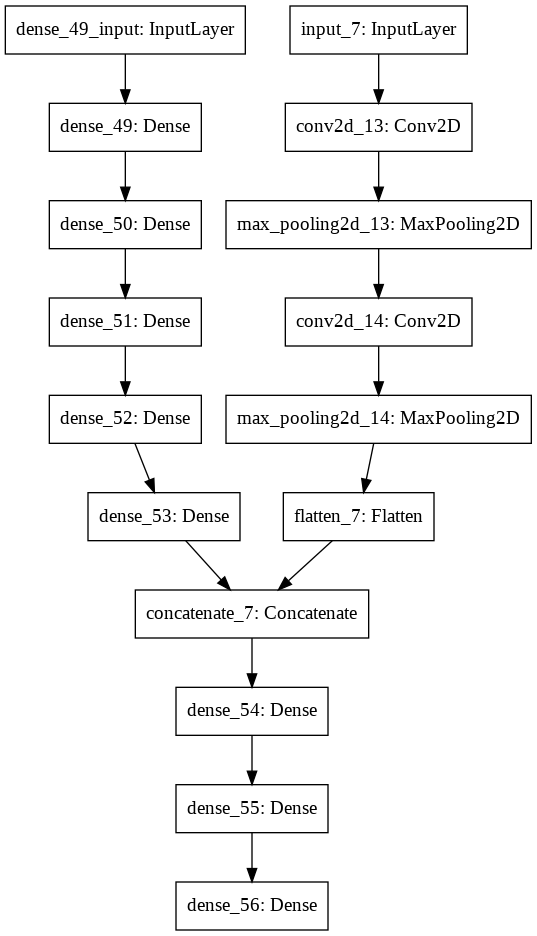

In [170]:

hidden1 = Dense(50, activation='relu')(merge)
hidden2 = Dense(40, activation='relu')(hidden1)
output = Dense(1, activation='relu')(hidden2)

model = Model(inputs=[model1.input, model2.input], outputs=output)
print(model.summary())


plot_model(model)

In [171]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath="drive/My Drive/best_weights_cnn1.hdf5", verbose=2, save_best_only=True) # save best model 

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=3, verbose=2, mode='auto')
model.fit([x_train, img_train], y_train,batch_size=64,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 288 samples, validate on 96 samples
Epoch 1/1000
 - 2s - loss: 543040558421.3333 - val_loss: 353763775829.3333
Epoch 2/1000
 - 0s - loss: 487134924344.8889 - val_loss: 257053021525.3333
Epoch 3/1000
 - 0s - loss: 343189400234.6666 - val_loss: 112338075648.0000
Epoch 4/1000
 - 0s - loss: 207047853852.4444 - val_loss: 157476951381.3333
Epoch 5/1000
 - 0s - loss: 190940131783.1111 - val_loss: 76151985493.3333
Epoch 6/1000
 - 0s - loss: 126581401827.5556 - val_loss: 44742153557.3333
Epoch 7/1000
 - 0s - loss: 65385673159.1111 - val_loss: 19871756970.6667
Epoch 8/1000
 - 0s - loss: 20238038129.7778 - val_loss: 16992634197.3333
Epoch 9/1000
 - 0s - loss: 12374053489.7778 - val_loss: 2338583125.3333
Epoch 10/1000
 - 0s - loss: 2417038122.6667 - val_loss: 1353369685.3333
Epoch 11/1000
 - 0s - loss: 1656830637.3333 - val_loss: 605000234.6667
Epoch 12/1000
 - 0s - loss: 1125077603.5556 - val_loss: 279033216.0000
Epoch 13/1000
 - 0s - loss: 1073434410.6667 - val_loss: 1294591232.0000
Epo

In [172]:

from sklearn import metrics

model_pred = model.predict([x_test,img_test])

score = np.sqrt(metrics.mean_squared_error(y_test,model_pred)) 

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,model_pred))
print("MSE          :", metrics.mean_squared_error(y_test, model_pred))

Score (RMSE) : 1701.689995829741
R2 score     : 0.9999795526802753
MSE          : 2895748.8419070244


In [0]:
model_pred = np.asarray(model_pred)
y_test = np.asarray(y_test)

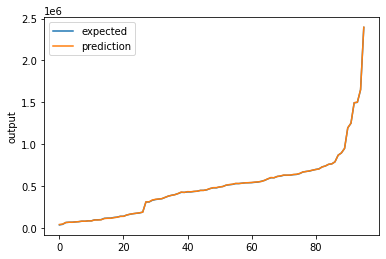

In [174]:

chart_regression(model_pred.flatten(),y_test)
